# Week 6 - Vector Space Word Embeddings

### Zhaoyang Chen

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

From this week's homework I will use the corpus of artwork descriptions downloaded from The Art Institute of Chicago offical website. 

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [2]:
#Load data into a dataframe
art_chicago_info_list = []
filename_list = []
repo = '../museum/'

for filename in os.listdir(repo):
    if 'artwork_description_metadata' in filename and not filename.startswith('.'):
        filename_list.append(filename)
        art_chicago_info_list.append(pd.read_csv(repo + '/' + filename, index_col=False))
        
art_chicago = pd.concat(art_chicago_info_list)

In [3]:
inds_list = []
for inds in [(file.split('_')[4], file.split('_')[5].split('.')[0]) for file in filename_list]:
    for ind in inds:
        if len(ind) == 4:
            inds_list.append(ind)
        elif len(ind) < 4:
            inds_list.append('0'*(4-len(ind)) + ind)
        else:
            print("Wrong")
print(f'The corpus contains the {sorted(inds_list)[0]}-{sorted(inds_list)[-1]} artworks')

The corpus contains the 0000-9500 artworks


In [4]:
#Basic information about the corpus
art_chicago.head()

,artwork_title,description_text,index,metadata,url
0,"“A” and the Carpenter I, 1973, Sam Gilliam",In the early 1960s Sam Gilliam began to experi...,1852.0,"Artist\nSam Gilliam\nTitle\n""A"" and the Carpen...",https://www.artic.edu/artworks/45860/a-and-the...
1,"The Baptism of Christ, 1500/05, Perugino",Perugino’s serene and decorous art was widely ...,1854.0,Artist\nPerugino\nTitle\nThe Baptism of Christ...,https://www.artic.edu/artworks/16197/the-bapti...
2,"Lovers Surprised by Death, 1510, Hans Burgkmai...","Themes derived from the Dance of Death, a medi...",1858.0,"Artist\nHans Burgkmair, the elder\nTitle\nLove...",https://www.artic.edu/artworks/147064/lovers-s...
3,"Calla Lilies, 1922/25, Arthur B. Carles","In 1922, Arthur B. Carles began a series of ca...",1860.0,Artist\nArthur B. Carles\nTitle\nCalla Lilies\...,https://www.artic.edu/artworks/193869/calla-li...
4,"Figure, 1927, Pablo Picasso",Head is an example of Pablo Picasso’s constant...,1863.0,Artist\nPablo Picasso\nTitle\nFigure\nOrigin\n...,https://www.artic.edu/artworks/75315/figure


In [5]:
#Normalize the data
art_chicago['tokenized_sents'] = art_chicago['description_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
art_chicago['normalized_sents'] = art_chicago['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

### 1. CBOW algorithmn for word2vec (one specification)

In [6]:
#Then we begin to investigate the word2vec of the data
artChicagoW2V = gensim.models.word2vec.Word2Vec(art_chicago['normalized_sents'].sum())

#### a. The most similar words of critical words of interest

In [7]:
# The most similar words of "eastern"
artChicagoW2V.most_similar('eastern')

[('described', 0.9998987317085266),
 ('cast', 0.999883770942688),
 ('way', 0.9998829364776611),
 ('music', 0.9998824596405029),
 ('order', 0.9998812675476074),
 ('religious', 0.9998801946640015),
 ('short', 0.9998748302459717),
 ('interest', 0.9998745322227478),
 ('classical', 0.9998744130134583),
 ('tradition', 0.9998711943626404)]

The word "religious", "classical", and "tradition" are the words that we picked out to describe eastern artworks. As we experienced from The Art Institute of Chicago, there are few Southeastern Asia Buddha statue in the musuem, maybe it captures these artworks.  

In [8]:
# The most similar words of "western"
artChicagoW2V.most_similar('western')

[('works', 0.9996896982192993),
 ('studies', 0.9996818900108337),
 ('national', 0.9995677471160889),
 ('exposition', 0.9995625019073486),
 ('director', 0.9995422959327698),
 ('joseph', 0.9995163679122925),
 ('history', 0.9994604587554932),
 ('purchased', 0.999447762966156),
 ('exhibition', 0.9994250535964966),
 ('african', 0.9993776679039001)]

As we can see, the artwork that has "eastern" features are most likely to origin in China and its theme (or description) is more related to the story behind that artwork. While for artworks that has "western" features, they are more likely to be related with the "design" of the artwork. 

In [9]:
# Try a typical art type "painting"
artChicagoW2V.most_similar('painting')

[('career', 0.999835193157196),
 ('came', 0.9998134970664978),
 ('study', 0.9997916221618652),
 ('sought', 0.9997866749763489),
 ('robert', 0.9997827410697937),
 ('inspiration', 0.9997800588607788),
 ('year', 0.9997772574424744),
 ('public', 0.9997771978378296),
 ('arts', 0.9997750520706177),
 ('worked', 0.9997703433036804)]

In [10]:
# Then for "sculpture"
artChicagoW2V.most_similar('statue')

[('canvas', 0.9998990893363953),
 ('power', 0.9998956918716431),
 ('cross', 0.9998933672904968),
 ('god', 0.9998911619186401),
 ('homer', 0.9998906850814819),
 ('seen', 0.9998899102210999),
 ('scene', 0.9998893737792969),
 ('case', 0.9998884201049805),
 ('birds', 0.9998868703842163),
 ('piece', 0.9998863935470581)]

As we can see, different kinds of artworks are related to different keywords here. However, these featured similar does not have any relationship or patterns worth mentioning. <br>
#### b. Analogies of critical words of insterest

In [11]:
#Western to eastern art
artChicagoW2V.most_similar(positive=['fine', 'western'], negative = ['eastern'])

[('american', 0.9994576573371887),
 ('exhibited', 0.9994387030601501),
 ('pop', 0.9994283318519592),
 ('pp', 0.9993122220039368),
 ('acquired', 0.9992586374282837),
 ('washington', 0.9986440539360046),
 ('collectors', 0.9985406398773193),
 ('exhibitions', 0.9984912872314453),
 ('shay', 0.9983938932418823),
 ('studies', 0.9982845783233643)]

It is interesting that from word2vec, "fine" to eastern is like "pop" to western, a good pattern here. 

In [13]:
artChicagoW2V.most_similar(positive=['fine', 'eastern'], negative = ['western'])

[('body', 0.999742865562439),
 ('christ', 0.9997046589851379),
 ('female', 0.9997013807296753),
 ('light', 0.9996953010559082),
 ('composition', 0.9996839761734009),
 ('colors', 0.9996703267097473),
 ('background', 0.999670147895813),
 ('lower', 0.9996666312217712),
 ('dark', 0.9996657371520996),
 ('upper', 0.999663233757019)]

If we have "fine" to western and its like... nothing explainable to eastern. No patterns here. 

In [14]:
artChicagoW2V.most_similar(positive=['modern', 'european'], negative = ['american'])

[('exhibition', 0.9994736909866333),
 ('cornell', 0.9993515014648438),
 ('studied', 0.9993457794189453),
 ('moved', 0.9992753267288208),
 ('student', 0.9992138147354126),
 ('history', 0.9991176128387451),
 ('galleries', 0.9990686178207397),
 ('national', 0.9990471005439758),
 ('city', 0.9990426301956177),
 ('photography', 0.9990336894989014)]

In [15]:
artChicagoW2V.most_similar(positive=['pop', 'european'], negative = ['american'])

[('member', 0.9992547035217285),
 ('private', 0.9992457628250122),
 ('fine', 0.9992141723632812),
 ('design', 0.999165415763855),
 ('collector', 0.9991580247879028),
 ('non', 0.9991469383239746),
 ('conceptual', 0.9991310834884644),
 ('historical', 0.9991296529769897),
 ('traditions', 0.9990769624710083),
 ('doubt', 0.9990592002868652)]

As we can see from the results above that the artwork that has the feature of "american" and "european" do not have any comparable relationship between each other. It might be due to that the styles of american and european artworks are much alike so that their differences cannot be represented by word2vec. Or there are also possibilities that there are too few artworks in the musuem that are "american" and "european", so that the texts derived from their description is too few in number to result is visible relationship. 

### 2. Skip-gram algorithmn for word2vec (another specification)

In [16]:
artChicagoW2V2 = gensim.models.word2vec.Word2Vec(art_chicago['normalized_sents'].sum(), sg=1, window=10)

#### a. The most similar words of critical words of interest

In [18]:
artChicagoW2V2.most_similar('eastern')

[('flourished', 0.9848282337188721),
 ('islamic', 0.9847248792648315),
 ('north', 0.9842336177825928),
 ('current', 0.9821068644523621),
 ('capital', 0.9790579676628113),
 ('population', 0.9783649444580078),
 ('sculptors', 0.9764782190322876),
 ('republic', 0.9763829112052917),
 ('southern', 0.9757758378982544),
 ('seymour', 0.9752249121665955)]

In [19]:
artChicagoW2V2.most_similar('western')

[('traditions', 0.9751195907592773),
 ('fashion', 0.9700777530670166),
 ('collectors', 0.9671387672424316),
 ('inspiration', 0.9627293348312378),
 ('folk', 0.9604143500328064),
 ('cultural', 0.9591021537780762),
 ('development', 0.9550399780273438),
 ('progressive', 0.9539046883583069),
 ('sought', 0.9525636434555054),
 ('crafts', 0.950937032699585)]

As we can see from the results above, changing the specifications in word2vec will largely change the results. The word "eastern" is now associated with adjectives like "flourished" and "islamic", while the "word" western is linked to adjectives like "folk" and "progessive". 

#### b. Analogies of critical words of insterest

In [20]:
artChicagoW2V2.most_similar(positive=['fine', 'western'], negative = ['eastern'])

[('original', 0.877883791923523),
 ('formal', 0.8771395087242126),
 ('qualities', 0.874545693397522),
 ('focus', 0.8733608722686768),
 ('demonstrate', 0.8641340732574463),
 ('pop', 0.8577686548233032),
 ('textile', 0.8538892865180969),
 ('pieces', 0.8462241291999817),
 ('found', 0.8454487323760986),
 ('aitken', 0.841490626335144)]

In [24]:
artChicagoW2V2.most_similar(positive=['fine', 'eastern'], negative = ['western'])

[('field', 0.930792510509491),
 ('built', 0.9279467463493347),
 ('subsequently', 0.9211926460266113),
 ('silk', 0.9190891981124878),
 ('scholars', 0.9181811213493347),
 ('pottery', 0.9153069853782654),
 ('newly', 0.9129520058631897),
 ('export', 0.9127002954483032),
 ('exquisite', 0.9114305973052979),
 ('amphora', 0.9109964966773987)]

As we can see from the results above, using another specification, the additions and subtractions using the same words are even harder to intercept.

In [25]:
artChicagoW2V2.most_similar(positive=['modern', 'european'], negative = ['american'])

[('western', 0.8521112203598022),
 ('culture', 0.8520412445068359),
 ('aesthetic', 0.8504147529602051),
 ('sought', 0.848166823387146),
 ('fashion', 0.8397554755210876),
 ('development', 0.8336559534072876),
 ('traditions', 0.8336248397827148),
 ('history', 0.8249714374542236),
 ('inspiration', 0.8207502365112305),
 ('favor', 0.8181821703910828)]

In [26]:
artChicagoW2V2.most_similar(positive=['pop', 'european'], negative = ['american'])

[('traditions', 0.8958461284637451),
 ('influence', 0.8953622579574585),
 ('western', 0.8948047757148743),
 ('fashion', 0.894469141960144),
 ('favor', 0.8921825885772705),
 ('non', 0.8894596099853516),
 ('spurned', 0.8883511424064636),
 ('innovative', 0.8876993656158447),
 ('islamic', 0.8869465589523315),
 ('progressive', 0.8864951729774475)]

Generally speaking, if we change the specifications of word2Vec from CBOW to skip-gram, and increase the window size to 10, the statistics of distance is smaller than the default specification. Also, the results we get are largely different too. 

#### c. Visualization

In [27]:
#Using PCA and TSNE specification for visualization.
numWords = 100
targetWords = artChicagoW2V.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(artChicagoW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

pcaWords = sklearn.decomposition.PCA(n_components = 100).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

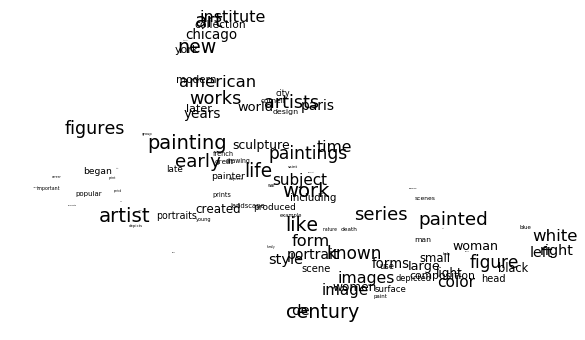

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

As we can see from the graph above, the words that we derive here are more of "functional" nouns and verbs rather than those that contain information about the artwork, like "painting", "figure", and "century". <br><br>
If we want to extract some patterns here, we can see that the word "painting" is close to "sculpture" and "painter", and the verb "painted" is related to "women", "series", and "figure". 

In [29]:
#Another visualization using incremental PCA
IncrePcaWords = sklearn.decomposition.IncrementalPCA(n_components = 100).fit(wordsSubMatrix)
reducedPCA_data = IncrePcaWords.transform(wordsSubMatrix)
#And use Locally Linear Embeddings...
tsneWords = sklearn.manifold.LocallyLinearEmbedding(n_components = 2).fit_transform(reducedPCA_data)

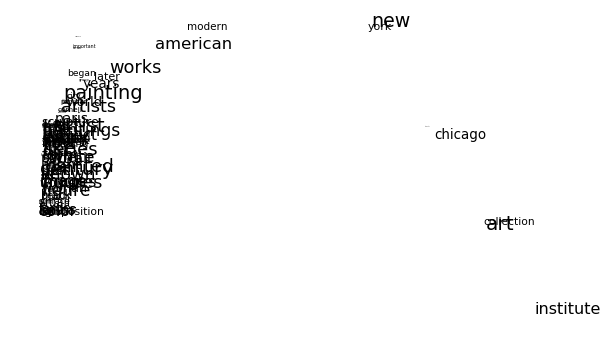

In [30]:
#Plot it
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

When using IncrementalPCA and Locally Linear Embeddings to visualize the vectors, we can see that the visualization is far from satisfying. Most of the words are all clustered in one direction of the graph, whose distance between one another is difficult to distinguish. While for the rest of them, their distances are relatively large and seems to be unrelated with the rest of the word subset. 

**Summary for Exercise 1** <br>
As illustrated from the analysis above, my corpus of musuem data does not reveal a clear semantic structure. The reason behind it might due to the limitation of the size of the corpora. Our corpora only contains the descriptions from The Art Institute of Chicago, which is a extremely minor subsample of all the artworks throughout the history globally. Hence we cannot derive patterns that aiming at revealing the overall semantic patterns of artworks. <br><br>
Also, with respect to visualization part, TNSE and PCA method generates the best visualization. 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [31]:
#Now update the corpus by specifying the title of the artwork
title_list = []
for sent in art_chicago['artwork_title']:
    temp = sent.split(',')
    title_list.append(temp[0])
art_chicago['title'] = title_list
art_chicago.head()

,artwork_title,description_text,index,metadata,url,tokenized_sents,normalized_sents,title
0,"“A” and the Carpenter I, 1973, Sam Gilliam",In the early 1960s Sam Gilliam began to experi...,1852.0,"Artist\nSam Gilliam\nTitle\n""A"" and the Carpen...",https://www.artic.edu/artworks/45860/a-and-the...,"[[In, the, early, 1960s, Sam, Gilliam, began, ...","[[early, 1960s, sam, gilliam, began, experimen...",“A” and the Carpenter I
1,"The Baptism of Christ, 1500/05, Perugino",Perugino’s serene and decorous art was widely ...,1854.0,Artist\nPerugino\nTitle\nThe Baptism of Christ...,https://www.artic.edu/artworks/16197/the-bapti...,"[[Perugino, ’s, serene, and, decorous, art, wa...","[[perugino, serene, decorous, art, widely, inf...",The Baptism of Christ
2,"Lovers Surprised by Death, 1510, Hans Burgkmai...","Themes derived from the Dance of Death, a medi...",1858.0,"Artist\nHans Burgkmair, the elder\nTitle\nLove...",https://www.artic.edu/artworks/147064/lovers-s...,"[[Themes, derived, from, the, Dance, of, Death...","[[themes, derived, dance, death, medieval, all...",Lovers Surprised by Death
3,"Calla Lilies, 1922/25, Arthur B. Carles","In 1922, Arthur B. Carles began a series of ca...",1860.0,Artist\nArthur B. Carles\nTitle\nCalla Lilies\...,https://www.artic.edu/artworks/193869/calla-li...,"[[In, 1922, Arthur, B., Carles, began, a, seri...","[[arthur, b., carles, began, series, calla, li...",Calla Lilies
4,"Figure, 1927, Pablo Picasso",Head is an example of Pablo Picasso’s constant...,1863.0,Artist\nPablo Picasso\nTitle\nFigure\nOrigin\n...,https://www.artic.edu/artworks/75315/figure,"[[Head, is, an, example, of, Pablo, Picasso, ’...","[[head, example, pablo, picasso, constant, exp...",Figure


In [46]:
#Now tokenize and normalize words not sentences
art_chicago['tokenized_words'] = art_chicago['description_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
art_chicago['normalized_words'] = art_chicago['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [50]:
art_chicago.head()

,artwork_title,description_text,index,metadata,url,tokenized_sents,normalized_sents,title,tagged_description,tokenized_words,normalized_words
0,"“A” and the Carpenter I, 1973, Sam Gilliam",In the early 1960s Sam Gilliam began to experi...,1852.0,"Artist\nSam Gilliam\nTitle\n""A"" and the Carpen...",https://www.artic.edu/artworks/45860/a-and-the...,"[[In, the, early, 1960s, Sam, Gilliam, began, ...","[[early, 1960s, sam, gilliam, began, experimen...",“A” and the Carpenter I,"([early, 1960s, sam, gilliam, began, experimen...","[In, the, early, 1960s, Sam, Gilliam, began, t...","[early, 1960s, sam, gilliam, began, experiment..."
1,"The Baptism of Christ, 1500/05, Perugino",Perugino’s serene and decorous art was widely ...,1854.0,Artist\nPerugino\nTitle\nThe Baptism of Christ...,https://www.artic.edu/artworks/16197/the-bapti...,"[[Perugino, ’s, serene, and, decorous, art, wa...","[[perugino, serene, decorous, art, widely, inf...",The Baptism of Christ,"([perugino, serene, decorous, art, widely, inf...","[Perugino, ’s, serene, and, decorous, art, was...","[perugino, serene, decorous, art, widely, infl..."
2,"Lovers Surprised by Death, 1510, Hans Burgkmai...","Themes derived from the Dance of Death, a medi...",1858.0,"Artist\nHans Burgkmair, the elder\nTitle\nLove...",https://www.artic.edu/artworks/147064/lovers-s...,"[[Themes, derived, from, the, Dance, of, Death...","[[themes, derived, dance, death, medieval, all...",Lovers Surprised by Death,"([themes, derived, dance, death, medieval, all...","[Themes, derived, from, the, Dance, of, Death,...","[themes, derived, dance, death, medieval, alle..."
3,"Calla Lilies, 1922/25, Arthur B. Carles","In 1922, Arthur B. Carles began a series of ca...",1860.0,Artist\nArthur B. Carles\nTitle\nCalla Lilies\...,https://www.artic.edu/artworks/193869/calla-li...,"[[In, 1922, Arthur, B., Carles, began, a, seri...","[[arthur, b., carles, began, series, calla, li...",Calla Lilies,"([arthur, b., carles, began, series, calla, li...","[In, 1922, Arthur, B., Carles, began, a, serie...","[arthur, b., carles, began, series, calla, lil..."
4,"Figure, 1927, Pablo Picasso",Head is an example of Pablo Picasso’s constant...,1863.0,Artist\nPablo Picasso\nTitle\nFigure\nOrigin\n...,https://www.artic.edu/artworks/75315/figure,"[[Head, is, an, example, of, Pablo, Picasso, ’...","[[head, example, pablo, picasso, constant, exp...",Figure,"([head, example, pablo, picasso, constant, exp...","[Head, is, an, example, of, Pablo, Picasso, ’s...","[head, example, pablo, picasso, constant, expe..."


In [51]:
from itertools import chain
#Now choose some important art styles type as keywords in this exercise
keywords = ['surrealism', 'impressionism', 'modern', 'pop', 'expressionism', 'cubism', 'realism', 'neoclassicism', 'renaissance']
taggedDocs = []
for index, row in art_chicago.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['title']) #Title is unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
art_chicago['tagged_description'] = taggedDocs

In [52]:
art_chicago['tagged_description'][1]

1    ([perugino, serene, decorous, art, widely, inf...
1    ([november, degas, monotype, landscapes, subje...
1    ([belle, ile, small, island, southern, shore, ...
1    ([door, palace, depicts, scenes, provide, glim...
1    ([visitors, germany, 17th, century, commented,...
                           ...                        
1    ([identical, dedicatory, inscriptions, cast, i...
1    ([half, length, format, jewel, like, painting,...
1    ([chivalric, tales, renaissance, especially, i...
1    ([like, african, americans, walter, ellison, l...
1    ([paul, cézanne, painted, work, prolonged, sta...
Name: tagged_description, Length: 190, dtype: object

In [54]:
#Train a Doc2Vec model
artD2V = gensim.models.doc2vec.Doc2Vec(art_chicago['tagged_description'], size = 100)

### 1. Word analogies (like exercise 1)

#### a. western to eastern art

In [55]:
artD2V.most_similar(positive=['fine', 'western'], negative = ['eastern'])

[('pp', 0.9994946122169495),
 ('photographer', 0.9993811845779419),
 ('exhibition', 0.9993659257888794),
 ('ill', 0.9993264079093933),
 ('o’keeffe', 0.9992262125015259),
 ('joseph', 0.9992132186889648),
 ('avenue', 0.9991186857223511),
 ('african', 0.9991023540496826),
 ('american', 0.9991000294685364),
 ('surrealism', 0.9990928173065186)]

In [56]:
artD2V.most_similar(positive=['fine', 'eastern'], negative = ['western'])

[('shaped', 0.9997824430465698),
 ('symbols', 0.9997790455818176),
 ('eyes', 0.9997725486755371),
 ('coin', 0.9997721910476685),
 ('arms', 0.999771237373352),
 ('mask', 0.9997705221176147),
 ('thick', 0.9997702240943909),
 ('god', 0.999767005443573),
 ('evoke', 0.9997649192810059),
 ('rendered', 0.9997648000717163)]

No patterns found here...

#### b. european to american art

In [57]:
artD2V.most_similar(positive=['modern', 'european'], negative = ['american'])

[('pop', 0.9962180256843567),
 ('guitarist', 0.995482325553894),
 ('museum', 0.995245635509491),
 ('whitney', 0.9947038292884827),
 ('metropolitan', 0.9945686459541321),
 ('architects', 0.9941460490226746),
 ('p.', 0.9940160512924194),
 ('league', 0.993520975112915),
 ('surrealist', 0.9927002191543579),
 ('deco', 0.9925746917724609)]

In [58]:
artD2V.most_similar(positive=['pop', 'european'], negative = ['american'])

[('school', 0.9987308979034424),
 ('dealer', 0.9986993670463562),
 ('columbian', 0.9978652596473694),
 ('studies', 0.9976280331611633),
 ('exhibited', 0.9976052641868591),
 ('illinois', 0.9975389838218689),
 ('gallery', 0.9975173473358154),
 ('metropolitan', 0.9972501993179321),
 ('acquired', 0.9971882700920105),
 ('joseph', 0.9969403147697449)]

The results show that american to modern is similar to european to pop, which is actually not the thing that we are expected...And the next result for american to pop and european to what is even less satisfying, which illustrates no explainable patterns. 

### 2. Most similar words in critical artworks

In [59]:
artD2V.docvecs.most_similar([artD2V['impressionism'] ], topn=5 )

[('realism', 0.998552680015564),
 ('pop', 0.9985290169715881),
 ('Washbowl', 0.9984998106956482),
 ('Homage to Tamara Toumanova', 0.9984709024429321),
 ('Fourth of July', 0.9984201192855835)]

Beside the words appearing here, we can see that the most representative work of impressionism in The Art Institute of Chicago is "Washbowl" by Edward Weston, who is a photographer of pictorialism style. Seems not right here. What ranked second is a painting by Joseph Cornell, "Homage to Tamara Toumanova". This is a painting, however, belongs to surrealism not impressionism. And the third one, "Fourth of July", is a photograph too. 

In [61]:
#Now let us look at the most similar words to the famous painting Nighthawks by Edward Hooper
artD2V.most_similar([artD2V.docvecs['Nighthawks'] ]) 

[('model', 0.9992702603340149),
 ('said', 0.9992620944976807),
 ('creating', 0.9992563724517822),
 ('sound', 0.9992518424987793),
 ('convey', 0.9992499351501465),
 ('response', 0.9992477893829346),
 ('book', 0.9992406964302063),
 ('production', 0.9992368221282959),
 ('free', 0.999235987663269),
 ('having', 0.9992321729660034)]

No valuable information revealed here. 

In [62]:
#Now look at analogies of additions and substractions of words
artD2V.docvecs.most_similar([artD2V['impressionism'] + artD2V['french']], topn=5 )

[('Mixed Behavior', 0.9998504519462585),
 ('Gold Pectoral with Zoomorphic Face', 0.9998139142990112),
 ('Burden Basket', 0.9998006224632263),
 ('Self-Portrait', 0.9997994899749756),
 ('Untitled (Harlequin)', 0.9997949600219727)]

The results shows top five artworks that has the feature of "impressionism" and "french". What ranked first is a video...But its photographer has her inspirations from Paris, that is really related to French. What ranked second is an ancient sculpture (or ornament) in Peru. What ranked third, "Burden Basket" is an actual basket from an Indian Tribe one hundred years old. Generally speaking, the results we found here is far from satisfying.  

In [63]:
#Now look at analogies of additions and substractions of words
artD2V.docvecs.most_similar([artD2V['pop'] + artD2V['american'] - artD2V['sculpture']], topn=5 )

[('From My Window at An American Place', 0.9630231857299805),
 ('Georgia O’Keeffe', 0.9487521648406982),
 ('Arthur G. Dove', 0.9443114995956421),
 ('From the Back-Window “291”', 0.9310410618782043),
 ('Spring Showers', 0.9296377301216125)]

Ah ha! There is some patterns shown here. Here we want to look at american pop artworks that is not a sculpture. The first item that appears is "From My Window at An American Place", which are a series of photographes that take the view New York, and their photographer is Georigia O'Keeffe, who ranked second in the list.

### 3. Visualization

In [64]:
#Plot the keywords similarities
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = artD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, artD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

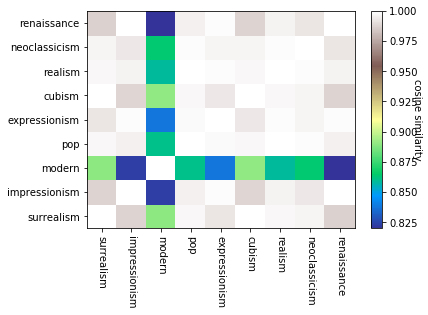

In [65]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

From the graph above we can see that all these art styles seems to be strongly related to one another except for one genre: modern. It has the least similarities with renaissance and impressionism. What worth mentioning here is that the values of cosine similarity we obtained here are much more larger than expected, which is a good question to be digged into in the future analysis. 

In [73]:
#Word similarities within artworks
targetDocs = art_chicago['title'][20:30]

heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = artD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, artD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

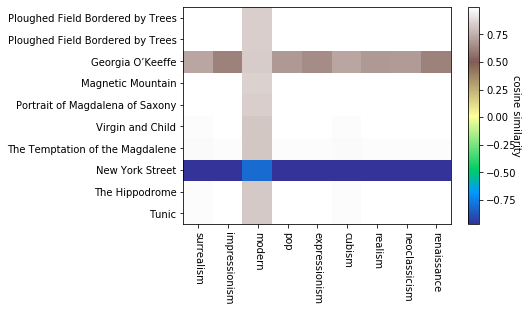

In [74]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

No visible & explainable patterns here. 

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [76]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [79]:
#Define my dimensions of interest
Reality = dimension(artChicagoW2V, ['real', 'realistic', 'true'], ['surreal', 'fantasy', 'imagine', 'imaginary'])
Pop = dimension(artChicagoW2V, ['modern', 'pop', 'temporary'], ['classic', 'traditional'])

In [102]:
#The words category are basically artists and some features
Human = ['girl', 'woman', 'man', 'child', 'boy', 'baby', 'lady', 'gentleman']
Objects = ['fruit', 'tree', 'bird', 'sea', 'vase', 'house', 'flower', 'water']

In [103]:
import pandas

def makeDF(model, word_list):
    r = []
    p = []
    for word in word_list:
        #a.append(sklearn.metrics.pairwise.cosine_similarity(artD2V.docvecs[word].reshape(1,-1), Artists.reshape(1,-1)[0][0]))
        r.append(sklearn.metrics.pairwise.cosine_similarity(artChicagoW2V[word].reshape(1,-1), Reality.reshape(1,-1))[0][0])
        p.append(sklearn.metrics.pairwise.cosine_similarity(artChicagoW2V[word].reshape(1,-1), Pop.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'reality': r, 'pop': p}, index = word_list)
    return df

In [104]:
#Get the projections
Humandf = makeDF(artChicagoW2V, Human)
Objectsdf = makeDF(artChicagoW2V, Objects)

In [105]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

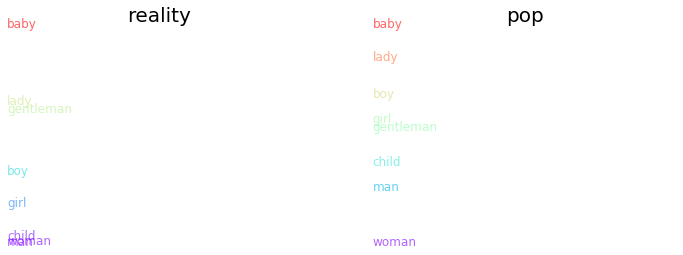

In [109]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
PlotDimension(ax1, Humandf, 'reality')
ax2 = fig.add_subplot(122)
PlotDimension(ax2, Humandf, 'pop')
plt.show()

From the graph above we can see that baby seems to appears more often in realism artworks rather than artworks that are "surreal" and "fantasy" themes. Also, since the word "lady" and "gentleman" are a little bit old-fashioned, so they are also more likely to be linked with realism artworks. By in the graph on the right, we can see a similar trend that "baby" is of traditional themes. "Women" also appears more in modern artworks than any other human figures.

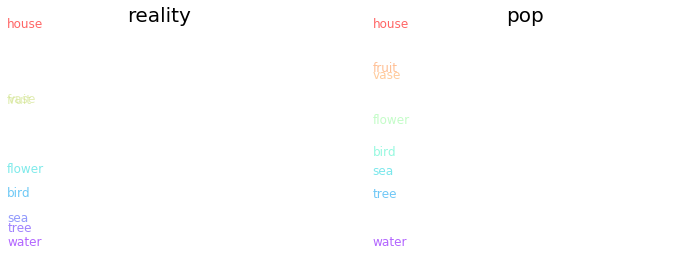

In [110]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
PlotDimension(ax1, Objectsdf, 'reality')
ax2 = fig.add_subplot(122)
PlotDimension(ax2, Objectsdf, 'pop')
plt.show()

From the graph above we can see that "house" is a common object that oftern appears in traditional and realism artworks, and it is more irrelevant to "pop" or "modern" or "surreal" than any other objects in the set. While water and trees are common features that artists capture to convey surreal meanings. 

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

In this question I choose the Wikipedia summary data for 20 famous western museum. The sample dataframe is described as below.

In [111]:
museum_set = ['Louvre', 'Zeitz_Museum_of_Contemporary_Art_Africa', 'National_Gallery_of_Canada', 'Tate_Modern',
             'Metropolitan_Museum_of_Art', 'Mauritshuis', 'National_Palace_Museum', 'Egyptian_Museum', 'Kunsthistorisches_Museum',
             'San_Francisco_Museum_of_Modern_Art', 'Museo_Nacional_de_Antropologia', 'Musée_D%27Orsay', 'Hermitage_Museum',
             'Museo_Nacional_del_Prado', 'The_National_Gallery', 'Rijksmuseum', 'Vasa_Museum', 'Acropolis_Museum',
             'The_British_Museum', 'Galleria_dell%27Accademia', 'Pergamon_Museum']

In [116]:
import requests
import bs4
import re

museum_dict = {}

for museum in museum_set:
    url = 'https://en.wikipedia.org/wiki/' + museum
    museumRequest = requests.get(url)
    museumContentSoup = bs4.BeautifulSoup(museumRequest.text, 'html.parser')
    PTags = museumContentSoup.body.findAll('p')
    paras = []
    for ptag in PTags:
        paras.append(re.sub(r'\[\d+\]', '', ptag.text))
    para_str = ' '.join(paras)
    print(para_str)
    museum_dict[museum] = para_str


 The Louvre (English: /ˈluːv(rə)/ LOOV(-rə)), or the Louvre Museum (French: Musée du Louvre [myze dy luvʁ] (listen)), is the world's  largest art museum and a historic monument in Paris, France. A central landmark of the city, it is located on the Right Bank of the Seine in the city's 1st arrondissement (district or ward). Approximately 38,000 objects from prehistory to the 21st century are exhibited over an area of 72,735 square meters (782,910 square feet). In 2019, the Louvre received 9.6 million visitors.
 The museum is housed in the Louvre Palace, originally built as the Louvre castle in the late 12th to 13th century under Philip II. Remnants of the fortress are visible in the basement of the museum. Due to urban expansion, the fortress eventually lost its defensive function, and in 1546 Francis I converted it into the primary residence of the French Kings. The building was extended many times to form the present Louvre Palace. In 1682, Louis XIV chose the Palace of Versailles fo

The Zeitz Museum of Contemporary Art Africa (Zeitz MOCAA) is a contemporary art museum located at the V&A Waterfront in Cape Town, South Africa. It is the largest museum of contemporary African art in the world.
 The museum opened on September 22, 2017.
 The public not-for-profit museum was commissioned through a public/private partnership between the V&A Waterfront and German businessman, Jochen Zeitz. The Waterfront invested over R500-million towards its construction and infrastructure development, and although not a shareholder, Zeitz has loaned his extensive art collection for his lifetime. Considered by many to be one of the world's leading collections of contemporary art from Africa and its Diaspora, Zeitz's collection includes works by such eminent artists as Chris Ofili, Kudzanai Chiurai, Kehinde Wiley, Glenn Ligon, Marlene Dumas, Wangechi Mutu, and Julie Mehretu.
 The Waterfront had been investigating a number of proposals regarding what to do with the historic Grain Silo sinc

Tate Modern is a modern art gallery located in London. It is Britain's national gallery of international modern art and forms part of the Tate group (together with Tate Britain, Tate Liverpool, Tate St Ives and Tate Online). It is based in the former Bankside Power Station, in the Bankside area of the London Borough of Southwark. Tate holds the national collection of British art from 1900 to the present day and international modern and contemporary art. Tate Modern is one of the largest museums of modern and contemporary art in the world. As with the UK's other national galleries and museums, there is no admission charge for access to the collection displays, which take up the majority of the gallery space, while tickets must be purchased for the major temporary exhibitions. The gallery is a highly visited museum, pulling in approximately 5.8 million visitors in 2018.
 Tate Modern is housed in the former Bankside Power Station, which was originally designed by Sir Giles Gilbert Scott, 


 The Metropolitan Museum of Art of New York City, colloquially "the Met",[a] is the largest art museum in the United States. With 6,953,927 visitors to its three locations in 2018, it was the third most visited art museum in the world. Its permanent collection contains over two million works, divided among 17 curatorial departments. The main building at 1000 Fifth Avenue, along the Museum Mile on the eastern edge of Central Park in Manhattan's Upper East Side, is by area one of the world's largest art galleries. A much smaller second location, The Cloisters at Fort Tryon Park in Upper Manhattan, contains an extensive collection of art, architecture, and artifacts from medieval Europe. On March 18, 2016, the museum opened the Met Breuer museum along Madison Avenue on the Upper East Side; it extends the museum's modern and contemporary art program.
 The permanent collection consists of works of art from classical antiquity and ancient Egypt, paintings, and sculptures from nearly all the

The Mauritshuis (Dutch pronunciation: [ˈmʌurɪtsɦœys]; English: Maurice House) is an art museum in The Hague, Netherlands. The museum houses the Royal Cabinet of Paintings which consists of 854 objects, mostly Dutch Golden Age paintings. The collections contains works by Johannes Vermeer, Rembrandt van Rijn, Jan Steen, Paulus Potter, Frans Hals, Jacob van Ruisdael, Hans Holbein the Younger, and others. Originally, the 17th century building was the residence of count John Maurice of Nassau. It is now the property of the government of the Netherlands and is listed in the top 100 Dutch heritage sites.
 In 1631, John Maurice, Prince of Nassau-Siegen, a cousin of stadtholder Frederick Henry, bought a plot bordering the Binnenhof and the adjacent Hofvijver pond in The Hague, at that time the political centre of the Dutch Republic. On the plot, the Mauritshuis was built as a home between 1636 and 1641, during John Maurice's governorship of Dutch Brazil. The Dutch Classicist building was design

The Museum of Egyptian Antiquities, known commonly as the Egyptian Museum or Museum of Cairo, in Cairo, Egypt, is home to an extensive collection of ancient Egyptian antiquities. It has 120,000 items, with a representative amount on display, the remainder in storerooms. Built in 1901 by the Italian construction company Garozzo-Zaffarani to a design by the French architect Marcel Dourgnon, the edifice is one of the largest museums in the region. As of March 2019, the museum is open to the public. In 2020 the museum is due to be superseded by the new Grand Egyptian Museum at Giza.
 The Egyptian Museum of Antiquities contains many important pieces of ancient Egyptian history. It houses the world's largest collection of Pharaonic antiquities. The Egyptian government established the museum built in 1835 near the Ezbekeyah Garden and later moved to the Cairo Citadel. In 1855, Archduke Maximilian of Austria was given all of the artifacts by the Egyptian government; these are now in the Kunsth

The National Museum of Anthropology (Spanish: Museo Nacional de Antropología, MNA) is a national museum of Mexico. It is the largest and most visited museum in Mexico. Located in the area between Paseo de la Reforma and Mahatma Gandhi Street within Chapultepec Park in Mexico City, the museum contains significant archaeological and anthropological artifacts from Mexico's pre-Columbian heritage, such as the Stone of the Sun (or the Aztec calendar stone) and the Aztec Xochipilli statue.
 The museum (along with many other Mexican national and regional museums) is managed by the Instituto Nacional de Antropología e Historia (National Institute of Anthropology and History), or INAH. It was one of several museums opened by Mexican President Adolfo López Mateos in 1964..
 Assessments of the museum vary, with one considering it "a national treasure and a symbol of identity. The museum is the synthesis of an ideological, scientific, and political feat." Octavio Paz criticized the museum's making


 The State Hermitage Museum (Russian: Госуда́рственный Эрмита́ж, tr. Gosudárstvennyj Ermitáž, IPA: [ɡəsʊˈdarstvʲɪnɨj ɪrmʲɪˈtaʂ]) is a museum of art and culture in Saint Petersburg, Russia. The second-largest art museum in the world, it was founded in 1764 when Empress Catherine the Great acquired an impressive collection of paintings from the Berlin merchant Johann Ernst Gotzkowsky. The museum celebrates the anniversary of its founding each year on 7 December, Saint Catherine's Day. It has been open to the public since 1852.
 Its collections, of which only a small part is on permanent display, comprise over three million items (the numismatic collection accounts for about one-third of them), including the largest collection of paintings in the world.[citation needed] The collections occupy a large complex of six historic buildings along Palace Embankment, including the Winter Palace, a former residence of Russian emperors. Apart from them, the Menshikov Palace, Museum of Porcelain, St


 The Prado Museum (/ˈprɑːdoʊ/ PRAH-doh; Spanish: Museo del Prado [muˈseo ðel ˈpɾaðo]), officially known as Museo Nacional del Prado, is the main Spanish national art museum, located in central Madrid. It is widely considered to have one of the world's finest collections of European art, dating from the 12th century to the early 20th century, based on the former Spanish Royal Collection, and the single best collection of Spanish art. Founded as a museum of paintings and sculpture in 1819, it also contains important collections of other types of works. The Prado Museum is one of the most visited sites in the world, and it is considered one of the greatest art museums in the world. The numerous works by Francisco Goya, the single most extensively represented artist, as well as by Hieronymus Bosch, El Greco, Peter Paul Rubens, Titian, and Diego Velázquez, are some of the highlights of the collection.
 The collection currently comprises around 8,200 drawings, 7,600 paintings, 4,800 prints,


 The National Gallery is an art museum in Trafalgar Square in the City of Westminster, in Central London. Founded in 1824, it houses a collection of over 2,300 paintings dating from the mid-13th century to 1900.[note 1]
 The Gallery is an exempt charity, and a non-departmental public body of the Department for Digital, Culture, Media and Sport. Its collection belongs to the government on behalf of the British public, and entry to the main collection is free of charge. It is among the most visited art museums in the world, after the Louvre, the British Museum, and the Metropolitan Museum of Art.
 Unlike comparable museums in continental Europe, the National Gallery was not formed by nationalising an existing royal or princely art collection. It came into being when the British government bought 38 paintings from the heirs of John Julius Angerstein in 1824. After that initial purchase the Gallery was shaped mainly by its early directors, notably Sir Charles Lock Eastlake, and by private


 The Rijksmuseum (Dutch: [ˈrɛiksmyˌzeːjʏm] (listen); English: National Museum) is a Dutch national museum dedicated to arts and history in Amsterdam. The museum is located at the Museum Square in the borough Amsterdam South, close to the Van Gogh Museum, the Stedelijk Museum Amsterdam, and the Concertgebouw.
 The Rijksmuseum was founded in The Hague on 19 November 1798 and moved to Amsterdam in 1808, where it was first located in the Royal Palace and later in the Trippenhuis. The current main building was designed by Pierre Cuypers and first opened in 1885. On 13 April 2013, after a ten-year renovation which cost € 375 million, the main building was reopened by Queen Beatrix. In 2013 and 2014, it was the most visited museum in the Netherlands with record numbers of 2.2 million and 2.47 million visitors. It is also the largest art museum in the country.
 The museum has on display 8,000 objects of art and history, from their total collection of 1 million objects from the years 1200–2000

The Vasa Museum (Swedish: Vasamuseet) is a maritime museum in Stockholm, Sweden. Located on the island of Djurgården, the museum displays the only almost fully intact 17th century ship that has ever been salvaged, the 64-gun warship Vasa that sank on her maiden voyage in 1628. The Vasa Museum opened in 1990 and, according to the official web site, is the most visited museum in Scandinavia. Together with other museums such as the Stockholm Maritime Museum, it belongs to the Swedish National Maritime Museums (SNMM).
 From the beginning of 1961 to 1988, Vasa was housed in a temporary structure called Wasavarvet ("The Vasa Shipyard") where she was treated with polyethylene glycol. Visitors could only view the ship from two levels and the maximum distance was only 5 m (17 ft). In 1981, the Swedish government decided that a permanent Vasa museum was to be constructed and a competition for the design of the museum building was organized. A total of 384 architects sent in models of their ideas


 The British Museum, in the Bloomsbury area of London, United Kingdom, is a public institution dedicated to human history, art and culture. Its permanent collection of some eight million works is among the largest and most comprehensive in existence, having been widely sourced during the era of the British Empire. It documents the story of human culture from its beginnings to the present.[a] It was the first public national museum in the world.
 The British Museum was established in 1753, largely based on the collections of the Irish physician and scientist Sir Hans Sloane. It first opened to the public in 1759, in Montagu House, on the site of the current building. Its expansion over the following 250 years was largely a result of expanding British colonisation and has resulted in the creation of several branch institutions, the first being the Natural History Museum in 1881.
 In 1973, the British Library Act 1972 detached the library department from the British Museum, but it contin


 The Galleria dell'Accademia di Firenze, or "Gallery of the Academy of Florence", is an art museum in Florence, Italy. It is best known as the home of Michelangelo's sculpture David. It also has other sculptures by Michelangelo and a large collection of paintings by Florentine artists, mostly from the period 1300–1600, the Trecento to the Late Renaissance.  It is smaller and more specialized than the Uffizi, the main art museum in Florence.  It adjoins the Accademia di Belle Arti or academy of fine arts of Florence, but despite the name has no other connection with it.
 In 2016, it had 1.46 million visitors, making it the second most visited art museum in Italy, after the Uffizi (2.02 million).
 The Galleria dell'Accademia was founded in 1784 by Pietro Leopoldo, Grand Duke of Tuscany.
 In 2001 the "Museo degli strumenti musicali" collection opened. It includes musical instruments made by Stradivarius, Niccolò Amati and Bartolomeo Cristofori.
 The Galleria dell'Accademia has housed the

In [118]:
museum_df = pandas.DataFrame(museum_dict.items(), columns=['museum_name', 'museum_description'])

In [120]:
for index, row in museum_df.iterrows():
    des = row['museum_description']
    row['museum_description'] = des.replace('\n', ' ')
    
museum_df

#Now handcode the location of each musuem to the dataframe
location = ['France', 'South Africa', 'Canada', 'UK', 'US', 'Netherlands', 'China', 'Egypt', 'Austria', 'US',
           '']

,museum_name,museum_description
0,Louvre,"The Louvre (English: /ˈluːv(rə)/ LOOV(-rə)),..."
1,Zeitz_Museum_of_Contemporary_Art_Africa,The Zeitz Museum of Contemporary Art Africa (Z...
2,National_Gallery_of_Canada,The National Gallery of Canada (French: Musée ...
3,Tate_Modern,Tate Modern is a modern art gallery located in...
4,Metropolitan_Museum_of_Art,The Metropolitan Museum of Art of New York C...
5,Mauritshuis,The Mauritshuis (Dutch pronunciation: [ˈmʌurɪt...
6,National_Palace_Museum,"The National Palace Museum,[note 1] located ..."
7,Egyptian_Museum,"The Museum of Egyptian Antiquities, known comm..."
8,Kunsthistorisches_Museum,"The Kunsthistorisches Museum (lit. ""Museum of ..."
9,San_Francisco_Museum_of_Modern_Art,Coordinates: 37°47′09″N 122°24′03″W﻿ / ﻿37.785...


In [121]:
location = ['France', 'South Africa', 'Canada', 'UK', 'US', 'Netherlands', 'China', 'Egypt', 'Austria', 'US', 'Mexico',
           'France', 'Russia', 'Spain', 'UK', 'Netherlands', 'Sweden', 'Greece', 'UK', 'Italy', 'Germany']
museum_df['location'] = location

In [123]:
#Now tokenize and normalize this dataframe
museum_df['tokenized_sents'] = museum_df['museum_description'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
museum_df['normalized_sents'] = museum_df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [124]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [127]:
#Change the specification of artChicago Word2Vec for the following function to work
artChicagoW2V3 = gensim.models.word2vec.Word2Vec(art_chicago['normalized_sents'].sum(), hs=1, negative=0)

In [128]:
#Now apply the function to every museum description
museum_df['likelihood'] = museum_df['normalized_sents'].apply(lambda x: adprob(x, artChicagoW2V3))

In [129]:
#The top 5 museum that is similar to The Art Institute of Chicago
for ad in museum_df.sort_values(by = 'likelihood', ascending = False)['museum_name'][:5]:
    print (ad + '\n\n')

Mauritshuis


Rijksmuseum


Vasa_Museum


Kunsthistorisches_Museum


Musée_D%27Orsay




We can see that the top five museums that are similar to The Art Institute of Chicago are Mauritshuis Museum in France, Rijkmuseum in Netherlands, Vasa Museum in Sweden, Kunsthistorisches Museum in Austria, and Musee D'Orsay in France.

In [130]:
#The last 5 museum that is similar to The Art Institute of Chicago
for ad in museum_df.sort_values(by = 'likelihood')['museum_name'][:5]:
    print (ad + '\n\n')

Metropolitan_Museum_of_Art


The_British_Museum


Museo_Nacional_del_Prado


San_Francisco_Museum_of_Modern_Art


The_National_Gallery




We can see from the results that the least similar museum in our sample. Interestingly, three of the five museums are in North America.

In [131]:
#Now group by the country these museums are in:
museum_df.groupby("location")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
location,
Netherlands,-47.586950
Sweden,-49.968277
Austria,-54.541698
China,-61.832558
Egypt,-64.187233
Greece,-64.900955
France,-65.114323
South Africa,-66.631729
Canada,-68.499519


Similar results is found in the table above. The Art Institute of Chicago seems to be different from other U.S. museums selected in our sample, which is an interesting result. 